In [4]:
%matplotlib inline

from tqdm.notebook import tqdm as tqdm

# Data Processing 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn import metrics

# Plotting 

from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

# Data

import numpy as np

## Utility Tools

import itertools as it
import pickle
import random
import umap
import gc
import os

gc.collect()

c:\MLAI\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\MLAI\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\MLAI\lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' dec

209

## Loading Data

In [5]:
dataset_name = "cifar"

if dataset_name == "cifar":
    dataset_path = r"C:\Users\ayush\OneDrive\Desktop\UoE\Dissertation\Implicit Networks\data\cifar"
    
if dataset_name == "mnist":
    dataset_path = r"C:\Users\ayush\OneDrive\Desktop\UoE\Dissertation\Implicit Networks\data\mnist" 

In [6]:
with open(os.path.join(dataset_path,"datasets",dataset_name+"_labels"), 'rb') as fp:
    targets = pickle.load(fp)

with open(os.path.join(dataset_path,"datasets","weights_dictionary.pkl"), 'rb') as fp:
    weights_dict = pickle.load(fp)

targets = np.array(targets) ##new

In [7]:
weights_array = np.array(tuple(weights_dict.values()))

## UMAP

In [41]:
reducer = umap.UMAP(random_state=42)

In [38]:
def plot_fig(embed,tg,digits): 

    """ Plot's UMAP clustering scatter plot

    Parameters:
    -----------
    embed : The embedding created by UMAP
    tg : The targets for each weight array or img
    digits: How amny digits are present (0-9)
    
    """

    plt.figure(figsize=(10,6))

    sc = plt.scatter(embed[:, 0], embed[:, 1], c=tg, cmap='Spectral', s=10)
    plt.gca().set_aspect('equal', 'datalim')
    plt.legend(handles=sc.legend_elements()[0], labels=list(digits), prop={'size': 10})

    plt.title("UMAP projection of digits {digit1} - {digit2} ".format(digit1 = digits[0],digit2 = digits[1] ), fontsize=15);
    plt.savefig(os.path.join(dataset_path,"plots\\umaps","{digit1}_{digit2}.pdf".format(digit1 = digits[0],digit2 = digits[1])))

In [39]:
def shuffle_arrays(arrays, set_seed=-1):
    
    """Shuffles arrays in-place, in the same order, along axis=0

    Parameters:
    -----------
    arrays : List of NumPy arrays.
    set_seed : Seed value if int >= 0, else seed is random.
    """
    assert all(len(arr) == len(arrays[0]) for arr in arrays)
    seed = np.random.randint(0, 2**(32 - 1) - 1) if set_seed < 0 else set_seed

    for arr in arrays:
        rstate = np.random.RandomState(seed)
        rstate.shuffle(arr)

In [40]:
def plot_umaps(weights,target,digits):

    wa = []
    ta = []

    for i in digits:

        index = np.where(target == i)

        weights_array_temp = weights[tuple(index)]
        targets_array_temp = np.ones(weights_array_temp.shape[0])*target[index[0][0]]

        wa.append(weights_array_temp)
        ta.append(targets_array_temp)


    wa = np.vstack(wa)
    ta = np.hstack(ta)

    shuffle_arrays([wa,ta])

    return wa,ta

In [ ]:
for a,b in it.combinations(np.arange(10), 2):

    ws,ts = plot_umaps(weights_array,targets,np.array([a,b]))

    embedding = reducer.fit_transform(np.delete(ws,np.s_[9050:-1],1))

    plot_fig(embedding,ts,np.array([a,b]))

## Classifier

In [14]:
def classifier(input_array,c_name,scale,pca_val = None):

    input_data = input_array

    
    if scale == True:
        
        scaler = StandardScaler()
        input_data = scaler.fit_transform(input_data)

    if pca_val != None:

        pca = PCA(n_components=pca_val)
        input_data = pca.fit_transform(input_data)
        

    x_train, x_test, y_train, y_test = train_test_split(input_data, targets, test_size=0.25, random_state=42)

    if c_name == "logit":

        logisticRegr = LogisticRegression(solver = 'lbfgs')
        logisticRegr.fit(x_train, y_train)

        y_pred = logisticRegr.predict(x_test)

        # Use score method to get accuracy of model
        test_accuracy = logisticRegr.score(x_test, y_test)
        train_accuracy = logisticRegr.score(x_train,y_train)
        
    if c_name == "forest":
        
        rf = RandomForestClassifier(n_estimators=300,max_depth=14)
        rf.fit(x_train, y_train)    

        y_pred = rf.predict(x_test)
        y_pred_train = rf.predict(x_train)

        test_accuracy = accuracy_score(y_test, y_pred)
        train_accuracy = accuracy_score(y_train, y_pred_train)
    
    # Metrics

    print("Test accuracy",test_accuracy,"Train accuracy",train_accuracy)
    print(y_test.shape,print(y_train.shape))
    cm = metrics.confusion_matrix(y_test, y_pred) # Confusion matrix

    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(test_accuracy)
    plt.title(all_sample_title, size = 15);
    # plt.savefig("C:/Users/ayush/OneDrive/Desktop/UoE/Dissertation/Implicit Networks/plots/metrics/{classifier}_{pca}.pdf".format(classifier = c_name,pca = pca_val))
    plt.savefig(os.path.join(dataset_path,"plots\\metrics","CIFAR_Weights_{classifier}_{pca}.pdf".format(classifier = c_name,pca = pca_val)))
        
    return 0

### Visualise

Test accuracy 0.1864 Train accuracy 0.9989333333333333
(7500,)
(2500,) None


0

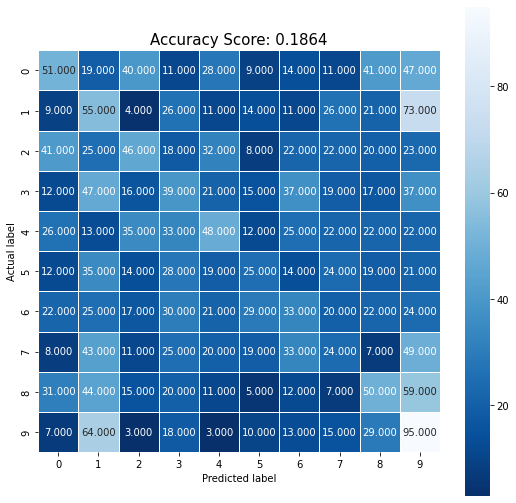

In [15]:
classifier(weights_array,'forest',True,200)

## Weight dictionary

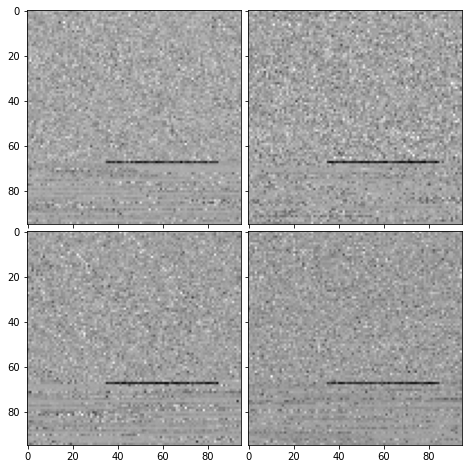

In [12]:
fig = plt.figure(figsize=(8., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid,random.sample(range(0, 10000), 4)):
    # Iterating over the grid returns the Axes.
    
    ax.imshow(weights_dict[str(im)][:9025].reshape(95,95),cmap = 'gray')
    fig.savefig(r"C:\Users\ayush\OneDrive\Desktop\UoE\Dissertation\Implicit Networks\plots\Observations\cifar_weights_plotted.pdf")
    plt.title("Weights array plotted for image no {image_no}".format(image_no=im))
plt.show()

In [ ]:
for x in np.where(targets==5)[0][1:]:

    print(np.linalg.norm(weights_dict['4'] - weights_dict[str((x))]))

## Archive

### SVM with RBF

In [ ]:
# from sklearn.svm import SVC, LinearSVC
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import accuracy_score

In [ ]:
# coefficient = []
# n_supp = []
# sup_vec = []
# i = 0
# df = pd.DataFrame(columns = ['c','gamma','train_acc','test_acc'])
# for c in [10]:
#     for g in [0.01]:
#         svm = SVC(kernel='rbf', C=c, gamma=g)
#         model = svm.fit(x_train, y_train)
#         globals()['model%s' % i] = model
#         d_coef = svm.dual_coef_
#         support = svm.n_support_
#         sv = svm.support_
    
#         p_tr = svm.predict(x_train)
#         a_tr = accuracy_score(y_train, p_tr)
    
#         pred = svm.predict(x_test)
#         a = accuracy_score(y_test, pred)
    
#         coefficient.append(d_coef)
#         n_supp.append(support)
#         sup_vec.append(sv)
#         df.loc[i] = [c,g,a_tr,a]
#         i=i+1



### UMAP Plot

In [ ]:
# list1 = np.array([0,5])

# wa = []
# ta = []

# for i in list1:

#     index = np.where(targets == i)

#     weights_array_temp = weights_array[tuple(index)]
#     targets_array_temp = np.ones(weights_array_temp.shape[0])*targets[index[0][0]]

#     wa.append(weights_array_temp)
#     ta.append(targets_array_temp)


# wa = np.vstack(wa)
# ta = np.hstack(ta)

# shuffle_arrays([wa,ta])

# embedding = reducer.fit_transform(np.delete(wa,np.s_[9050:-1],1))

# plot_fig(embedding,ta,list1,5)

In [ ]:
# weights_pd = pd.DataFrame.from_dict(weights)
# weights_pd['digit'] = pd.Series(targets).map(lambda x: 'Digit {}'.format(x))

In [ ]:
# def plot_embedding(interval=19):

#     for i in range(interval):

#         embedding = reducer.fit_transform(np.delete(weights_array,np.s_[500+i:-1],1))

#         plot_fig(embedding,targets,500+i)

#     embedding = reducer.fit_transform(np.delete(weights_array,np.s_[9049+i:-1],1))
#     plot_fig(embedding,targets,9049)


In [ ]:
# with open("../data/labels", 'rb') as fp:
#     targets = pickle.load(fp)

# with open('../data/weights_dictionary.pkl', 'rb') as fp:
#     weights = pickle.load(fp)

# targets = np.array(targets) ##new